# **Project Title: Automated Quality Control (Defect Detection)**
Product Brand Name: “VisionSpec QC”



### **DeepPCB Dataset**
DeepPCB: a dataset contains 1,500 image pairs, each of which consists of a defect-free template image and an aligned tested image with annotations including positions of 6 most common types of PCB defects: open, short, mousebite, spur, pin hole and spurious copper.

This project automate PCB quality inspection, which is traditionally done manually and is time-consuming, error-prone, and costly. In high-speed manufacturing lines, even small defects can cause major product failures.

By using computer vision and deep learning, this system can:

* Detect PCB defects quickly and accurately

* Reduce human inspection effort

* Improve manufacturing reliability and consistency

* Enable real-time quality control in production environments


## **Task 1: Data Preparation – Robust Data Augmentation**

In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

print(os.listdir("/content/drive/MyDrive/PCBData"))

['test.txt', 'trainval.txt', 'group90100', 'group12000', 'group12300', 'group77000', 'group50600', 'group44000', 'group92000', 'group20085', 'group13000', 'group12100', 'group00041']


In [3]:
print(os.listdir("/content/drive/MyDrive/PCBData/group12000/12000"))

['12000187_temp.jpg', '12000068_temp.jpg', '12000136_temp.jpg', '12000102_test.jpg', '12000204_test.jpg', '12000155_test.jpg', '12000171_temp.jpg', '12000038_test.jpg', '12000102_temp.jpg', '12000204_temp.jpg', '12000085_temp.jpg', '12000052_test.jpg', '12000155_temp.jpg', '12000593_test.jpg', '12000119_test.jpg', '12000187_test.jpg', '12000038_temp.jpg', '12000171_test.jpg', '12000017_temp.jpg', '12000001_temp.jpg', '12000068_test.jpg', '12000052_temp.jpg', '12000119_temp.jpg', '12000593_temp.jpg', '12000136_test.jpg', '12000085_test.jpg', '12000001_test.jpg', '12000017_test.jpg']


**Split Data into train/validation**

In [4]:
import shutil #helps you manage files and folders efficiently
import random

In [5]:
#Define Paths
SOURCE_DIR = "/content/drive/MyDrive/PCBData"
TARGET_DIR = "/content/drive/MyDrive/PCBData_split"

TRAIN_RATIO = 0.8  # 80% train, 20% validation

In [6]:
#Create Folder Structure
classes = ["defect", "normal"]

for split in ["train", "val"]: #It creates folders for training and validation data
    for cls in classes: #Inside each split (train, val), it creates class-wise subfolders
        os.makedirs(os.path.join(TARGET_DIR, split, cls), exist_ok=True)

| Part            | Purpose                       |
| --------------- | ----------------------------- |
| `os.path.join`  | Builds correct folder path    |
| `os.makedirs`   | Creates folders               |
| `exist_ok=True` | Avoids duplicate-folder error |


| Filename contains | Label  |
| ----------------- | ------ |
| `_test`           | defect |
| `_temp`           | normal |


In [7]:
#Collect All Images
def get_all_images(source_dir):
    image_paths = []
    for root, _, files in os.walk(source_dir): #os.walk() scans through every folder and file inside source_dir
        for file in files:
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

all_images = get_all_images(SOURCE_DIR)
print("Total images found:", len(all_images))

Total images found: 3001


In [8]:
#Split & Copy Images
random.seed(42) #fixes randomness so results are reproducible.
random.shuffle(all_images)

split_index = int(len(all_images) * TRAIN_RATIO) #calculates where to split the dataset based on TRAIN_RATIO.
train_images = all_images[:split_index] #gets the training portion of images.
val_images = all_images[split_index:] #gets the remaining images for validation.

In [9]:
#Copy Images to Train/Val Folders (This function copies images into train/val folders based on their labels)
def copy_images(image_list, split_type):
    for img_path in image_list:
        filename = os.path.basename(img_path)

        if "_test" in filename:
            label = "defect" #If the filename contains _test, the image is labeled defect.
        elif "_temp" in filename:
            label = "normal" #If the filename contains _temp, the image is labeled normal.
        else:
            continue  # skip unknown files

        target_path = os.path.join(TARGET_DIR, split_type, label, filename) #os.path.join(...) builds the destination file path where the image should go.
        shutil.copy(img_path, target_path) #shutil.copy(...) copies the image from its original location to this target folder.

copy_images(train_images, "train")
copy_images(val_images, "val") #Each image is copied to the correct class folder inside train or val.

In [10]:
#Verify Dataset
for split in ["train", "val"]: #The loop goes through train and validation folders.
    print(f"\n{split.upper()} SET") #It prints the dataset split name (TRAIN SET, VAL SET).
    for cls in classes:
        path = os.path.join(TARGET_DIR, split, cls)
        print(cls, ":", len(os.listdir(path))) #os.listdir(path) lists files in that class folder.


TRAIN SET
defect : 1187
normal : 1213

VAL SET
defect : 313
normal : 288


**Training Generator (WITH augmentation)**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( #generates modified images on the fly to improve model generalization.
    rescale=1./255, #Normalizes pixel values to 0–1
    rotation_range=20, #Randomly rotates images ±20°
    width_shift_range=0.1,
    height_shift_range=0.1, #Randomly shifts images horizontally/vertically
    zoom_range=0.15, #Randomly zooms in/out
    horizontal_flip=True, #Randomly flips images left-right
    brightness_range=[0.8, 1.2], #Randomly changes brightness
    fill_mode="nearest" #Fills missing pixels after transformations
)

**Validation Generator (NO augmentation)**

In [12]:
val_datagen = ImageDataGenerator(
    rescale=1./255
)

**Create Data Loaders**

prepares image data for training and validation using Keras generators

In [13]:
TRAIN_DIR = "/content/drive/MyDrive/PCBData_split/train"
VAL_DIR = "/content/drive/MyDrive/PCBData_split/val" #Paths to train and validation folders

IMG_SIZE = (224, 224) #Resizes all images to 224×224 pixels
BATCH_SIZE = 32 #Number of images per batch during training

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",#Suitable for two-class classification (defect vs normal)
    shuffle=True
) #Loads images from TRAIN_DIR, applies augmentation, shuffles data

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
) #Loads images from VAL_DIR, no augmentation, does not shuffle

Found 2400 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


| Generator  | Shuffle | Reason            |
| ---------- | ------- | ----------------- |
| Train      |  Yes   | Better learning   |
| Validation |  No    | Stable evaluation |


In [14]:
#Verify class mapping
print(train_generator.class_indices)

{'defect': 0, 'normal': 1}


**Visualize the augmented images**

In [15]:
#Get ONE batch from the training generator
# Get one augmented batch
images, labels = next(train_generator) #retrieves one batch of images and labels from the training generator

print("Batch image shape:", images.shape)
print("Batch label shape:", labels.shape)

Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)


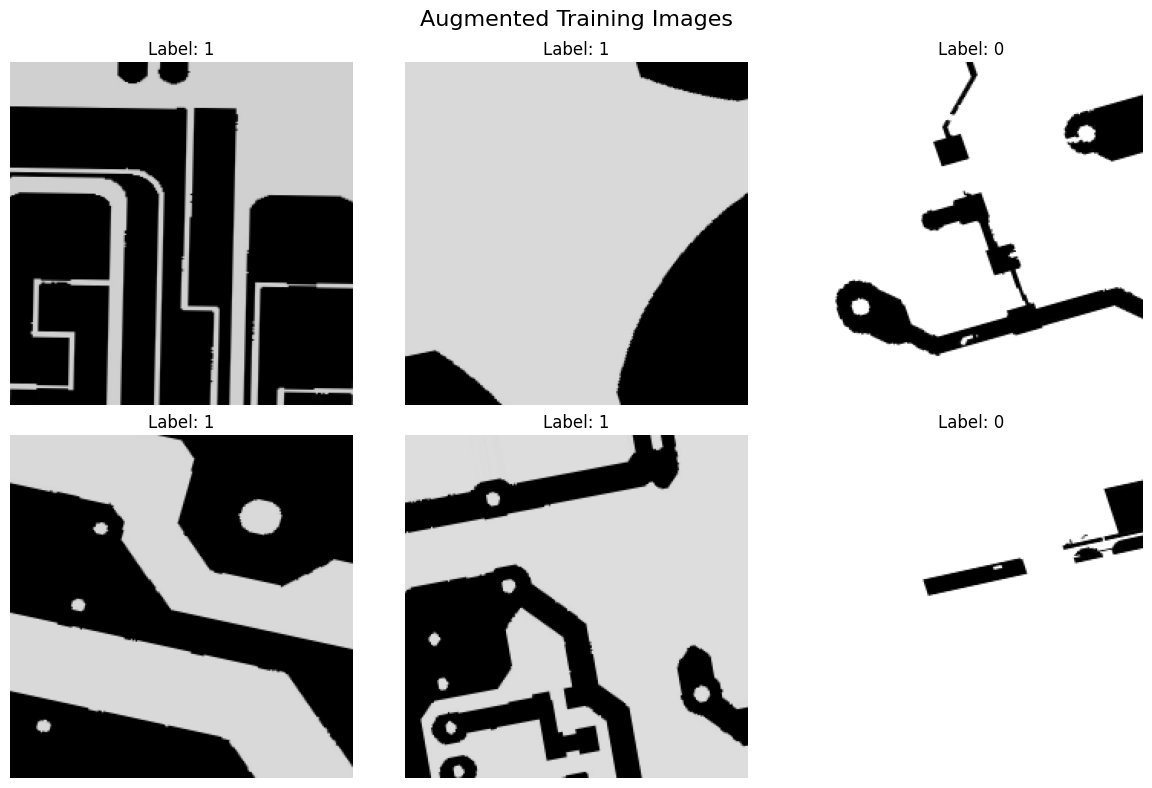

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

for i in range(6):  # show 6 augmented images
    plt.subplot(2, 3, i + 1)

    # Images are rescaled → convert back to [0,255]
    img = (images[i] * 255).astype("uint8") #.astype("uint8") → Changes data type to unsigned 8-bit integer, standard for images

    plt.imshow(img)
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")

plt.suptitle("Augmented Training Images", fontsize=16)
plt.tight_layout()
plt.show()

##**Task 2: Core Modeling – Transfer Learning**

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

MobileNetV2 → lightweight, fast, production-friendly

EarlyStopping → stops training if validation loss increases

ModelCheckpoint → saves best model automatically

**Load Pre-trained MobileNetV2**

In [18]:
base_model = MobileNetV2(
    weights="imagenet", #Uses pre-trained ImageNet weights for feature extraction
    include_top=False,      #Removes the original classification layers so we can add our custom classifier
    input_shape=(224, 224, 3) #Specifies input image size (224×224 RGB)
)

**Freeze Base Model**

In [19]:
base_model.trainable = False #freezes the pre-trained MobileNetV2 layers

These layers won’t be updated during training.

Only the new classifier layers we add on top will be trained

**Build Custom Classification Head**

In [20]:
x = base_model.output #Takes the features from MobileNetV2
x = GlobalAveragePooling2D()(x) #Reduces feature maps to a 1D vector
x = Dense(128, activation="relu")(x) #Fully connected layer with 128 neurons
x = Dropout(0.3)(x) #Randomly drops 30% of neurons to prevent overfitting
output = Dense(1, activation="sigmoid")(x)  #Output layer for binary classification (defect vs normal).

model = Model(inputs=base_model.input, outputs=output) #Creates the final Keras model combining the base and new layers

**Compile the Model**

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), #Uses Adam optimizer with a small learning rate for stable training
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

Low learning rate protects pre-trained weights

Binary cross-entropy for 2 classes

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Callbacks to Prevent Overfitting**

In [23]:
callbacks = [
    EarlyStopping( #stops when validation loss worsens
        monitor="val_loss",
        patience=5, #Stops training if val_loss doesn’t improve for 5 epochs (patience=5)
        restore_best_weights=True #Keeps the best model weights.
    ),
    ModelCheckpoint( #keeps best model only
        "best_mobilenet_pcb.h5", #Saves the model to "best_mobilenet_pcb.h5" whenever val_loss improves
        monitor="val_loss",
        save_best_only=True #Only saves the best version of the model
    )
]

**Train the Model**

In [24]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5400 - loss: 0.7513

75/75 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.5405 - loss: 0.7508 - val_accuracy: 0.6273 - val_loss: 0.6377
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6565 - loss: 0.6105

75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.6565 - loss: 0.6105 - val_accuracy: 0.6905 - val_loss: 0.5990
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6731 - loss: 0.6013

75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.6732 - loss: 0.6011 - val_accuracy: 0.6988 - val_loss: 0.5811
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6901 - loss: 0.5615

75/75 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.6901 - loss: 0.5614 - val_accuracy: 0.7038 - val_loss: 0.5650
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7338 - loss: 0.5326

75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.7337 - loss: 0.5327 - val_accuracy: 0.7138 - val_loss: 0.5425
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7359 - loss: 0.5337

75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.7359 - loss: 0.5336 - val_accuracy: 0.7255 - val_loss: 0.5405
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7483 - loss: 0.5096

75/75 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.7483 - loss: 0.5096 - val_accuracy: 0.7288 - val_loss: 0.5213
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7561 - loss: 0.4801

75/75 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.7560 - loss: 0.4802 - val_accuracy: 0.7155 - val_loss: 0.5157
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7508 - loss: 0.4935

75/75 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.7508 - loss: 0.4934 - val_accuracy: 0.7205 - val_loss: 0.5118
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7660 - loss: 0.4866

75/75 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.7660 - loss: 0.4865 - val_accuracy: 0.7354 - val_loss: 0.5056
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7628 - loss: 0.4659

75/75 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.7628 - loss: 0.4659 - val_accuracy: 0.7371 - val_loss: 0.5018
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.7583 - loss: 0.4872 - val_accuracy: 0.7421 - val_loss: 0.5024
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.7999 - loss: 0.4404 - val_accuracy: 0.7238 - val_loss: 0.5019
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7778 - loss: 0.4502

75/75 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.7779 - loss: 0.4502 - val_accuracy: 0.7404 - val_loss: 0.4894
Epoch 15/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7562 - loss: 0.4681

75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.7564 - loss: 0.4679 - val_accuracy: 0.7521 - val_loss: 0.4857
Epoch 16/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8132 - loss: 0.4168 - val_accuracy: 0.7371 - val_loss: 0.4863
Epoch 17/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8087 - loss: 0.4171

75/75 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.8085 - loss: 0.4171 - val_accuracy: 0.7537 - val_loss: 0.4821
Epoch 18/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8085 - loss: 0.4192

75/75 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.8086 - loss: 0.4192 - val_accuracy: 0.7454 - val_loss: 0.4817
Epoch 19/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.7924 - loss: 0.4219 - val_accuracy: 0.7504 - val_loss: 0.4868
Epoch 20/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8025 - loss: 0.4175

75/75 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.8024 - loss: 0.4175 - val_accuracy: 0.7454 - val_loss: 0.4769
Epoch 21/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8122 - loss: 0.4076 - val_accuracy: 0.7488 - val_loss: 0.4920
Epoch 22/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8067 - loss: 0.4146

75/75 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.8067 - loss: 0.4146 - val_accuracy: 0.7587 - val_loss: 0.4709
Epoch 23/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8024 - loss: 0.4142 - val_accuracy: 0.7454 - val_loss: 0.4822
Epoch 24/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.8200 - loss: 0.3878 - val_accuracy: 0.7521 - val_loss: 0.4762
Epoch 25/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.8165 - loss: 0.3868 - val_accuracy: 0.7571 - val_loss: 0.4731
Epoch 26/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8090 - loss: 0.3947 - val_accuracy: 0.7521 - val_loss: 0.4830
Epoch 27/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.8303 - loss: 0.3820 - val_accuracy: 0.7488 - val_loss: 0.4796


**Plot Learning Curves**

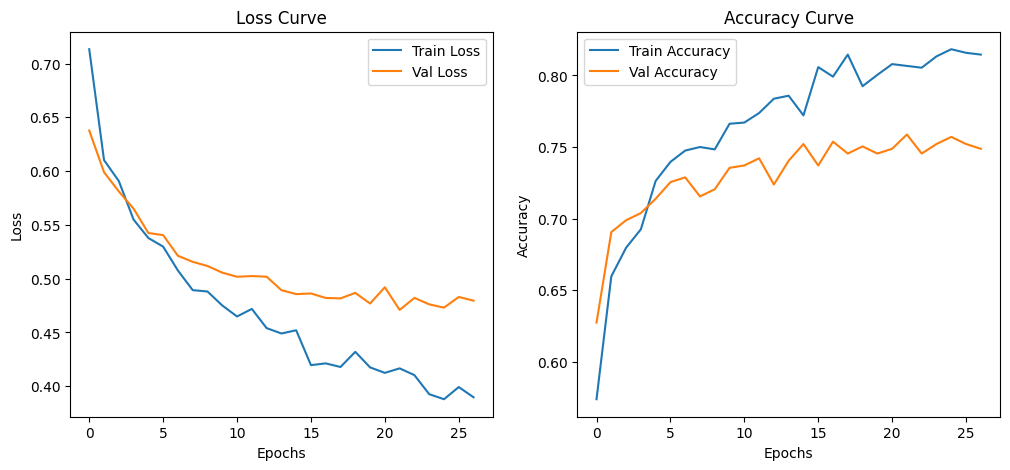

In [25]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

Loss Curve

* Training loss steadily decreases, showing the model is learning well.

* Validation loss also decreases and then stabilizes, without increasing.

* The small gap between train and validation loss indicates no serious overfitting.

Accuracy Curve

* Training accuracy increases consistently across epochs.

* Validation accuracy improves and stabilizes around 74–76%.

* The validation curve follows the training curve closely, showing good generalization.

Overall Conclusion

* The model is learning effectively.

* Overfitting is well controlled.

* Training was stopped at a good point where validation performance is stable

##**Task 3: Interpretability**

**Grad-CAM**
* Grad-CAM stands for Gradient-weighted Class Activation Mapping.
* Grad-CAM shows where a deep learning model is looking in an image to make its decision.
* It creates a heatmap that highlights the important regions of the image used by the model for prediction.

          Red / yellow areas → very important
          Blue areas → less important

**Why Grad-CAM?**

Grad-CAM helps us:

* Visually verify model decisions

* Build trust in predictions

* Ensure the CNN focuses on actual defects (solder joints / components)

In [26]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

**Load Trained Model**

In [27]:
model = tf.keras.models.load_model("best_mobilenet_pcb.h5") #loads the best-performing PCB defect detection model (saved during training using ModelCheckpoint)

**Load & Preprocess Image**

In [28]:
def preprocess_image(img_path, img_size=(224, 224)): #Defines a function to prepare an image for MobileNetV2
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)#Loads the image from disk and resizes it to 224×224, which MobileNetV2 expects.
    img_array = tf.keras.preprocessing.image.img_to_array(img)#Converts the image into a NumPy array so it can be processed by the model.
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)#Normalizes pixel values exactly as MobileNetV2 was trained on ImageNet.
    return np.expand_dims(img_array, axis=0), img #Adds a batch dimension & Returns both processed image (for prediction) and original image (for Grad-CAM visualization)

**Grad-CAM Heatmap Generation**

In [29]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name): #Defines a function to generate a Grad-CAM heatmap for a given image.
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    ) #Creates a new model that outputs: Feature maps from the last convolution layer & Final prediction scores

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        class_score = predictions[:, class_index] #Runs a forward pass, Selects the predicted class, Gets the score of that class

    grads = tape.gradient(class_score, conv_outputs) #Computes gradients of the class score with respect to feature maps, Tells how important each feature map is
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) #Averages gradients spatially & Produces importance weights for each feature map

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis] #Multiplies feature maps by their importance & Combines them into a single heatmap
    heatmap = tf.squeeze(heatmap) #Removes unnecessary dimensions

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap) #Keeps only positive values & Normalizes heatmap between 0 and 1
    return heatmap.numpy() #Converts heatmap to NumPy array for visualization

**Overlay Heatmap on Original Image**

In [30]:
def overlay_heatmap(img, heatmap, alpha=0.4): #Defines a function to overlay a Grad-CAM heatmap on the original image, alpha controls heatmap transparency
    img = np.array(img) #Converts the image to a NumPy array for OpenCV processing
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) #Resizes the heatmap to match the image size
    heatmap = np.uint8(255 * heatmap) #Converts heatmap values from 0–1 → 0–255.
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) #Applies a color map (blue → red) to make important regions visible
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0) #Blends the original image and heatmap together.
    return overlay #Returns the final visualization image

**Full Grad-CAM Visualization**

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


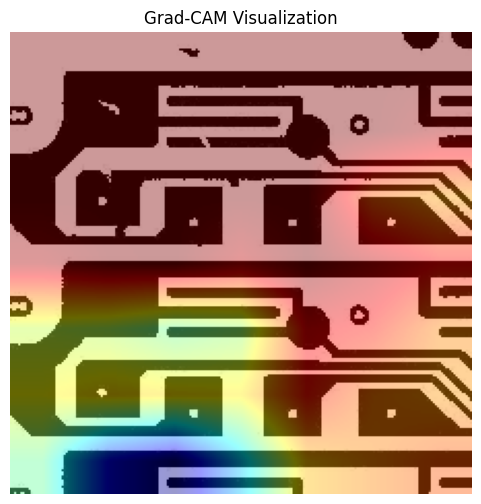

In [33]:
img_path = "/content/drive/MyDrive/PCBData/group12000/12000/12000102_test.jpg"

img_array, original_img = preprocess_image(img_path) #Preprocesses it for MobileNetV2 prediction
#Returns: img_array → model-ready image, original_img → original image for visualization
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="Conv_1"  # MobileNetV2 last conv layer
) #Generates a Grad-CAM heatmap

overlay_img = overlay_heatmap(original_img, heatmap) #Overlays the heatmap on the original image & Produces a visual explanation of model attention

plt.figure(figsize=(6, 6))
plt.imshow(overlay_img)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()

* The colored heatmap is overlaid on the original PCB image.

* The strong red and yellow regions are concentrated on PCB tracks and junctions (solder paths and connection points).

* These areas are structurally important for detecting defects like breaks, shorts, or irregular patterns.

* The model is not focusing on empty background regions, which is a good sign.

##**Task 4: Inference Optimization**

* OpenCV is a library that helps computers “see” and understand images and videos.
* OpenCV is mainly used for real-time image and video processing.


**Load Optimized Model (Saved .h5)**

In [34]:
# Load trained & optimized model
model = tf.keras.models.load_model(
    "/content/best_mobilenet_pcb.h5"
)

print("Model loaded successfully")

Model loaded successfully


In [42]:
IMG_SIZE = 224  # MobileNetV2 input size

def preprocess_frame(frame): #Defines a function to prepare a frame before giving it to the model.
    if frame is None:
        raise ValueError("Frame is empty. Check image path.")

    frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE)) #Resizes the frame to the size expected by the model
    frame = frame.astype("float32") / 255.0 #Converts pixel values from 0–255 to 0–1
    frame = np.expand_dims(frame, axis=0) #Adds a batch dimension
    return frame

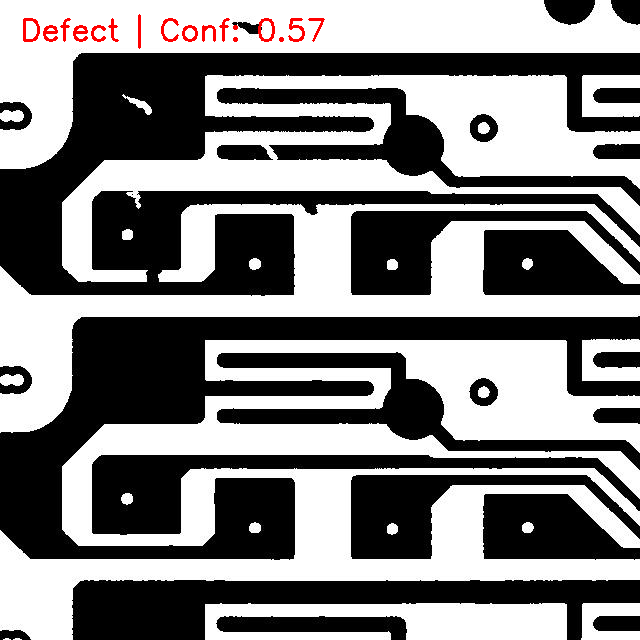

In [44]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load image
img_path = "/content/drive/MyDrive/PCBData/group12000/12000/12000102_test.jpg"
frame = cv2.imread(img_path) #Reads a PCB image

# Preprocess
input_tensor = preprocess_frame(frame) ##Resizes image to model size (e.g., 224×224), Normalizes pixel values, Adds batch dimension

# Prediction
preds = model.predict(input_tensor, verbose=0)
confidence = preds[0][0] #Model outputs probability of Defect, Higher value → more confident defect

if confidence > 0.5:
    label = "Defect"
    color = (0, 0, 255)   # Red
else:
    label = "Normal"
    color = (0, 255, 0)   #≤ 50% → Normal (Green)

# Draw result
text = f"{label} | Conf: {confidence:.2f}"
cv2.putText(
    frame,
    text,
    (20, 40),
    cv2.FONT_HERSHEY_SIMPLEX,
    1,
    color,
    2
)

# Show image (Colab-safe)
cv2_imshow(frame)

**Prediction Output Analysis**

Prediction: Defect


Confidence: 0.57 (57%)

What this means:

* The model has classified the PCB image as Defective.

* A confidence of 0.57 means the model is only moderately sure.

* This value is just above the decision threshold (0.5), so the prediction is borderline, not very strong.